In [1]:
import ta
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.12.0


In [2]:
# Read data
df = pd.read_csv('./2019_AAPL_1min.csv', header=0, index_col=0)
df.index = pd.to_datetime(df.index).tz_localize(None).to_period('T')

In [3]:
# Add label
df['label'] = (df.close.shift(-1) - df.close).apply(lambda x: 0 if x < 0 else 1)

In [4]:
# Technical indicators
momentum_indicators = ['roc', 'rsi', 'tsi']
volatility_indicators = ['bb_bbhi', 'bb_bbli']
trend_indicators = ['aroon_down', 'aroon', 'aroon_up', 'macd_line', 'macd_hist', 'macd_signal', 
                    'kst', 'kst_diff', 'kst_signal', 'dpo', 'trix', 'sma_10', 'sma_20', 'sma_30', 'sma_60',
                    'ema_10', 'ema_20', 'ema_30', 'ema_60']
volume_indicators = ['obv', 'vpt', 'fi', 'nvi']

In [5]:
for indicator in momentum_indicators:
    df[indicator] = getattr(ta.momentum, indicator)(close=df.close)

In [6]:
# Volatility indicators
bb_indicator = ta.volatility.BollingerBands(close=df.close)
df['bb_bbhi'] = bb_indicator.bollinger_hband_indicator()
df['bb_bbli'] = bb_indicator.bollinger_lband_indicator()

In [7]:
# Trend indicators
aroon_indicator = ta.trend.AroonIndicator(high=df['high'], low=df['low'])
macd_indicator = ta.trend.MACD(close=df['close'])

# Add trend indicators to DataFrame
df['aroon_down'] = aroon_indicator.aroon_down()
df['aroon'] = aroon_indicator.aroon_indicator()
df['aroon_up'] = aroon_indicator.aroon_up()

df['macd_line'] = macd_indicator.macd()
df['macd_hist'] = macd_indicator.macd_diff()
df['macd_signal'] = macd_indicator.macd_signal()

In [8]:
for indicator in volume_indicators:
    if indicator == 'obv':
        df[indicator] = ta.volume.on_balance_volume(close=df.close, volume=df.volume)
    elif indicator == 'vpt':
        df[indicator] = ta.volume.volume_price_trend(close=df.close, volume=df.volume)
    elif indicator == 'fi':
        df[indicator] = ta.volume.force_index(close=df.close, volume=df.volume)
    elif indicator == 'nvi':
        df[indicator] = ta.volume.negative_volume_index(close=df.close, volume=df.volume)

In [9]:
# Time features
df['datetime'] = df.index.to_timestamp()
time_features = ['minute', 'hour', 'day', 'month']
for feature in time_features:
    df[f'{feature}_sin'] = np.sin(2 * np.pi * getattr(df.datetime.dt, feature) / (30 if feature == 'day' else 60))

In [10]:
# Drop unnecessary columns
df = df.drop(['datetime'], axis=1)

In [11]:
# Split data
df_na = df.dropna(axis=0)
labels = df_na.label
df_na = df_na.drop(['label'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_na.values, labels.values, test_size=0.05, random_state=42)

In [12]:
# Standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# PCA
pca = PCA(n_components=0.8, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [14]:
# Classifier models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

In [15]:
# Train and evaluate models
for name, model in models.items():
    model.fit(X_train_pca, y_train)
    y_pred = model.predict_proba(X_test_pca)
    acc = accuracy_score(y_test, y_pred.argmax(axis=1))
    f1 = f1_score(y_test, y_pred.argmax(axis=1))
    roc = roc_auc_score(y_test, y_pred[:, 1])
    print(f'{name}: acc={acc*100:.2f}% - f1={f1*100:.2f}% - roc={roc*100:.2f}%')

Logistic Regression: acc=58.22% - f1=72.64% - roc=55.93%
Decision Tree: acc=53.47% - f1=59.47% - roc=52.48%
Random Forest: acc=56.60% - f1=64.63% - roc=57.78%
Gradient Boosting: acc=58.28% - f1=73.04% - roc=57.39%


In [17]:
import seaborn as sns

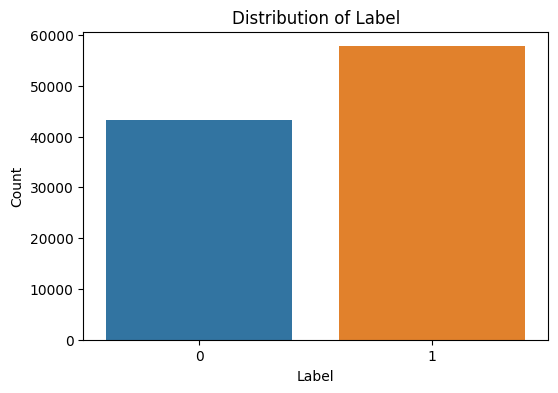

In [19]:
# Visualize distribution of label
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()